In [94]:
from tqdm.notebook import tqdm as tq
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# %load models.py
import layers
import torch
import torch.nn as nn
import torch.nn.functional as F

# 12 layers!
# k: number of filters to use in intermediate conv layers
# parallels AlphaGo + res layers
class convNet(nn.Module):
    def __init__(self, k, batchNorm = False):
        super(convNet, self).__init__()
        if batchNorm:
            self.model = nn.Sequential(
                layers.symConv2D(55, k, 5),
                nn.BatchNorm2d(k),
                nn.ReLU(),
                layers.resBlock(k),
                layers.resBlock(k),
                layers.resBlock(k),
                layers.resBlock(k),
                layers.resBlock(k), # resBlock # 5 (layer 11)
                layers.OutputLayer(k) # layer 12
            )
        else:
            self.model = nn.Sequential(
                layers.symConv2D(55, k, 5),
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.symConv2D(k, k, 3), # layer 5
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.symConv2D(k, k, 3), # layer 10
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.OutputLayer(k) # layer 12
            )

    def forward(self, x):
        return self.model(x)

In [11]:
# %load util.py
import torch
from torch.utils.data import Dataset
import sys
import random
import os
import numpy as np
from datetime import datetime as dt
import glob
from collections import Counter
from sgfmill import sgf
from sgfmill import boards
from sgfmill import ascii_boards
from tqdm import tqdm as tq

class GoDataset(Dataset):
  # pos_paths: list of paths to position features
  # labels: list of moves played in a given position
  def __init__(self, pos_paths, label_paths):
        self.label_paths = label_paths
        self.pos_paths = pos_paths

  def __len__(self):
        return len(self.pos_paths)

  def __getitem__(self, idx):
        pos = torch.load(self.pos_paths[idx])
        pos = pos.permute(2, 0, 1)
        correctClass= torch.load(self.label_paths[idx])
        label = correctClass[0] * 19 + correctClass[1]
        return pos, label

def getPaths(prefix):
    fullDataPaths = []
    fullLabelPaths = []
    for rank in ['5k', '4k', '3k', '2k', '1k', '1d', '2d', '3d', '4d']:
        data = glob.glob(prefix + "data/" + rank + "/*.pt")
        labels = glob.glob(prefix + "labels/" + rank + "/*.pt")
        for i in tq(range(len(data))):
            assert data[i].rsplit('/', 1)[1] == labels[i].rsplit('/', 1)[1]
        fullDataPaths.extend(data)
        fullLabelPaths.extend(labels)
    return fullDataPaths, fullLabelPaths

def getCorrectCount(pred, y):
    # pred: batch_size x 361
    # y: batch_size
    return (torch.argmax(pred, dim = 1) == y).sum()

def buildFeatures(positions):
    # input: 19 x 19 x 3 input: my stones, their stones, empty spots
    # output: 19 x 19 x 32: 
    # 0 - 7 liberties 
    # 8 - 15 self capture size
    # 16 - 23 capture size
    # 24 - 31 liberties after move
    # candidates: open 1 liberty slots for opponent stones
    n = positions.shape[0]

    
    visited = positions[:, :, 2] - 1
    output = torch.zeros((n, n, 32))
    candidates = []
    libertyMap = dict()
    stoneMap = dict()
    colorMap = dict()
    
    def getLiberties(x, y, color, placeholder):
        firstLiberty = None
        liberties = 0
        stoneCount = 1
        visited[x][y] = placeholder
        visited2[x][y] = 1
        if x > 0:
            if visited2[x - 1][y] == 0:
                visited2[x - 1][y] = 1
                if positions[x - 1][y][2] == 1:
                    if liberties == 0:
                        firstLiberty = [x - 1, y]
                    liberties += 1
                elif positions[x - 1][y][color] == 1:
                    l, s, fl = getLiberties(x - 1, y, color, placeholder)
                    if liberties == 0:
                        firstLiberty = fl
                    liberties += l
                    stoneCount += s
        if x < n - 1:
            if visited2[x + 1][y] == 0:
                visited2[x + 1][y] = 1
                if positions[x + 1][y][2] == 1:
                    if liberties == 0:
                        firstLiberty = [x + 1, y]
                    liberties += 1
                elif positions[x + 1][y][color] == 1:
                    l, s, fl = getLiberties(x + 1, y, color, placeholder)
                    if liberties == 0:
                        firstLiberty = fl
                    liberties += l
                    stoneCount += s
        if y > 0:
            if visited2[x][y - 1] == 0:
                visited2[x][y - 1] = 1
                if positions[x][y - 1][2] == 1:
                    if liberties == 0:
                        firstLiberty = [x, y - 1]
                    liberties += 1
                elif positions[x][y - 1][color] == 1:
                    l, s, fl = getLiberties(x, y - 1, color, placeholder)
                    if liberties == 0:
                        firstLiberty = fl
                    liberties += l
                    stoneCount += s
        if y < n - 1:
            if visited2[x][y + 1] == 0:
                visited2[x][y + 1] = 1
                if positions[x][y + 1][2] == 1:
                    if liberties == 0:
                        firstLiberty = [x, y + 1]
                    liberties += 1
                elif positions[x][y + 1][color] == 1:
                    l, s, fl = getLiberties(x, y + 1, color, placeholder)
                    if liberties == 0:
                        firstLiberty = fl
                    liberties += l
                    stoneCount += s
        
        return liberties, stoneCount, firstLiberty
    
    counter = 1
    for i in range(n):
        for j in range(n):
            # visited: -1 if stone is there, 0 if no stone there, counter if visited + stone present
            if visited[i][j] == -1: 
                # visited2: for each loop through connected stones, 1 if visited or liberty has been checked
                visited2 = torch.zeros_like(visited) 
                color = int(positions[i][j][1] == 1) # 0 if your stone, 1 if opponent stone
                l, s, fl = getLiberties(i, j, color, counter)
                libertyMap[counter] = l
                stoneMap[counter] = s
                colorMap[counter] = color # 0 = my color, 1 = their color
                if l == 1 and color == 1:
                    candidates.append((fl[0], fl[1])) # simpleKo candidate: may not be legal move for me to capture
                if l == 1:
                    output[fl[0]][fl[1]][min(s, 8) - 1 + 8 * (color + 1)] = 1 # mark self captures / captures
                counter += 1
    for i in range(n):
        for j in range(n):
            x = int(visited[i][j].item())
            if x == 0: # mark liberties after move
                if i > 0:
                    key = int(visited[i - 1][j].item())
                    if key != 0 and colorMap[key] == 1:
                        l = libertyMap[key]
                        output[i][j][min(l, 8) + 23] = 1
                if i < n - 1:
                    key = int(visited[i + 1][j].item())
                    if key != 0 and colorMap[key] == 1:
                        l = libertyMap[key]
                        output[i][j][min(l, 8) + 23] = 1
                if j > 0:
                    key = int(visited[i][j - 1].item())
                    if key != 0 and colorMap[key] == 1:
                        l = libertyMap[key]
                        output[i][j][min(l, 8) + 23] = 1
                if j < n - 1:
                    key = int(visited[i][j + 1].item())
                    if key != 0 and colorMap[key] == 1:
                        l = libertyMap[key]
                        output[i][j][min(l, 8) + 23] = 1
            else:
                l = libertyMap[x]
                output[i][j][min(l, 8) - 1] = 1 # mark liberty counts for each stone location
            
    return output, candidates 

# 55 features
# 0-2: stone positions
# 3-4: all 0's, all 1's
# 5-12: turn history
# 13 - 36: liberties, self captures, captures
# 37 - 44: liberties after move
# 45: simple ko constraint
# 46 - 54: one hot encoding for rank
def gameToFeatures(game):
    swapColor = {'w': 'b', 'b': 'w'}
    root_node = game.get_root()
    b = boards.Board(19)
    
    rankOneHot = None
    for rankInd, rank in enumerate(['5çº§', '4çº§', '3çº§', '2çº§', '1çº§', '1æ®µ', '2æ®µ', '3æ®µ', '4æ®µ']):        
        if root_node.get("BR") == rank and root_node.get("WR") == rank:
            assert rankOneHot == None
            rankOneHot = rankInd
    assert rankOneHot != None
    
    features = []
    labels = []
    counter = 0
    for node in game.get_main_sequence():
        color, move = node.get_move()
        #print(color, move)
        feature = torch.zeros(19, 19, 55)
        if color == None:
            feature[:, :, 2] = 1
            feature[:, :, 4] = 1
            feature[:, :, 46 + rankOneHot] = 1
        else:
            labels.append([move[0], move[1]])
            b.play(move[0], move[1], color)
            for c, p in b.list_occupied_points():
                if c != color:
                    # my color: c / their color: color (last move made)
                    feature[p[0], p[1], 0] = 1
                else:
                    feature[p[0], p[1], 1] = 1
            feature[:, :, 2] = (feature[:, :, 0] + feature[:, :, 1]) == 0
            feature[:, :, 4] = 1
            feature[move[0], move[1], 5] = 1
            # moves 1-7 history from last feature => 2-8 history of current feature
            feature[:, :, 6:13] = features[-1][:, :, 5:12] 
            feature[:, :, 13:45], candidates = buildFeatures(feature[:, :, :3])
            feature[:, :, 45] = checkSimpleKo(oldb, b, candidates, swapColor[color])
            feature[:, :, 46 + rankOneHot] = 1
        features.append(feature)
        counter += 1
        oldb = b.copy()
    return features[:-1], labels

def checkSimpleKo(past, present, candidates, color):
    n = 19
    output = torch.zeros((n, n))
    for x, y in candidates:
        variation = present.copy()
        try: 
            variation.play(x, y, color)
            if variation.list_occupied_points() == past.list_occupied_points():
                output[x][y] = 1
        except Exception:
            pass
    return output

def filterGame(game, rank):
    board_size = game.get_size()
    if board_size != 19:
        return False
    root_node = game.get_root()
    if root_node.get("BR") != rank:
        return False
    if root_node.get("WR") != rank:
        return False
    if root_node.get("RU") != "Japanese":
        return False
    if root_node.get("TM") != 600:
        return False
    if root_node.get("KM") != 0:
        return False
    if dt.strptime(root_node.get("DT"), '%Y-%m-%d').year != 2017:
        return False
    return True 

In [72]:
!ls models

convFull	     testConvNoRes250240  testConvWRes150144
test10112	     testConvNoRes300288  testConvWRes200192
test128		     testConvNoRes350336  testConvWRes250240
test20224	     testConvNoRes400384  testConvWRes300288
test40448	     testConvNoRes450432  testConvWRes350336
test50048	     testConvNoRes50048   testConvWRes400384
testConvNoRes100096  testConvNoRes500480  testConvWRes450432
testConvNoRes150144  testConvNoRes550528  testConvWRes50048
testConvNoRes200192  testConvWRes100096   testConvWRes500480


In [6]:
model = convNet(128)

In [74]:
#model = torch.load("models/testConvNoRes550528")
model = torch.load("models/testConvWRes500480")

In [75]:
model

convNet(
  (model): Sequential(
    (0): symConv2D()
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): resBlock(
      (conv1): symConv2D()
      (conv2): symConv2D()
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): resBlock(
      (conv1): symConv2D()
      (conv2): symConv2D()
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): resBlock(
      (conv1): symConv2D()
      (conv2): symConv2D()
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (6): resBlock(
      (conv1): symCon

In [12]:
ranks = ['5k', '4k', '3k', '2k', '1k', '1d', '2d', '3d', '4d'] 

In [14]:
testData = []
testLabels = []
for rank in ranks:
    data = glob.glob("../cleanedGoData/test/data/" + rank + "/*.pt")
    labels = glob.glob("../cleanedGoData/test/labels/" + rank + "/*.pt")
    testData.append(data)
    testLabels.append(labels)

In [17]:
len(testData[0])

31941

In [ ]:
'''def getCorrectCount(pred, y):
    # pred: batch_size x 361
    # y: batch_size
    return (torch.argmax(pred, dim = 1) == y).sum()

In [79]:
accs = []
device = torch.device('cuda:0')
for i in range(1, len(ranks)):
    print("building dataset for rank: ", ranks[i])
    test_data = GoDataset(testData[i], testLabels[i])
    test_loader = DataLoader(test_data, batch_size = 128, shuffle = False, num_workers = 4)
    count = 0
    with tq(total=len(test_loader.dataset)) as progress_bar:
        for batch, (X, y) in enumerate(test_loader):
            X = X.to(device)
            batch_size = X.shape[0]
            pred = model(X)
            y = y.to(device)
            progress_bar.update(batch_size)
            count += getCorrectCount(pred, y)
    acc = count / len(test_loader.dataset)
    print("accuracy: ", acc)
    accs.append(acc)
torch.save(accs, "accs.pt")

building dataset for rank:  4k


  0%|          | 0/32023 [00:00<?, ?it/s]

accuracy:  tensor(0.4516, device='cuda:0')
building dataset for rank:  3k


  0%|          | 0/32334 [00:00<?, ?it/s]

accuracy:  tensor(0.4609, device='cuda:0')
building dataset for rank:  2k


  0%|          | 0/34316 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb96585d050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb96585d050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

accuracy:  tensor(0.4469, device='cuda:0')
building dataset for rank:  1k


  0%|          | 0/32793 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb96585d050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb96585d050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

accuracy:  tensor(0.4492, device='cuda:0')
building dataset for rank:  1d


  0%|          | 0/29619 [00:00<?, ?it/s]

accuracy:  tensor(0.4323, device='cuda:0')
building dataset for rank:  2d


  0%|          | 0/30418 [00:00<?, ?it/s]

accuracy:  tensor(0.4445, device='cuda:0')
building dataset for rank:  3d


  0%|          | 0/30973 [00:00<?, ?it/s]

accuracy:  tensor(0.4349, device='cuda:0')
building dataset for rank:  4d


  0%|          | 0/31218 [00:00<?, ?it/s]

accuracy:  tensor(0.4247, device='cuda:0')


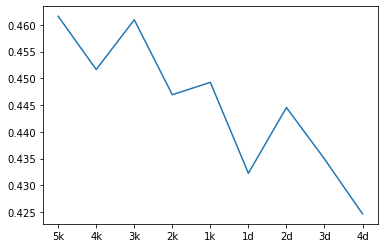

In [99]:
plt.plot(ranks, accs)

In [107]:
valDPaths, valLPaths = getPaths("../cleanedGoData/val/") 

  0%|          | 0/32505 [00:00<?, ?it/s]

  0%|          | 0/30276 [00:00<?, ?it/s]

  0%|          | 0/32120 [00:00<?, ?it/s]

  0%|          | 0/31421 [00:00<?, ?it/s]

  0%|          | 0/33065 [00:00<?, ?it/s]

  0%|          | 0/32256 [00:00<?, ?it/s]

  0%|          | 0/31045 [00:00<?, ?it/s]

  0%|          | 0/31018 [00:00<?, ?it/s]

  0%|          | 0/30736 [00:00<?, ?it/s]

In [114]:
valDPaths

['../cleanedGoData/val/data/5k/326884.pt',
 '../cleanedGoData/val/data/5k/337064.pt',
 '../cleanedGoData/val/data/5k/326239.pt',
 '../cleanedGoData/val/data/5k/340828.pt',
 '../cleanedGoData/val/data/5k/334363.pt',
 '../cleanedGoData/val/data/5k/334790.pt',
 '../cleanedGoData/val/data/5k/334825.pt',
 '../cleanedGoData/val/data/5k/322637.pt',
 '../cleanedGoData/val/data/5k/335619.pt',
 '../cleanedGoData/val/data/5k/321790.pt',
 '../cleanedGoData/val/data/5k/337141.pt',
 '../cleanedGoData/val/data/5k/347182.pt',
 '../cleanedGoData/val/data/5k/343997.pt',
 '../cleanedGoData/val/data/5k/335001.pt',
 '../cleanedGoData/val/data/5k/329876.pt',
 '../cleanedGoData/val/data/5k/331297.pt',
 '../cleanedGoData/val/data/5k/339690.pt',
 '../cleanedGoData/val/data/5k/322744.pt',
 '../cleanedGoData/val/data/5k/326499.pt',
 '../cleanedGoData/val/data/5k/325960.pt',
 '../cleanedGoData/val/data/5k/333972.pt',
 '../cleanedGoData/val/data/5k/346842.pt',
 '../cleanedGoData/val/data/5k/340108.pt',
 '../cleane

In [101]:
valDPaths

['../cleanedGoData/val/data/4k/331170.pt',
 '../cleanedGoData/val/data/1d/339021.pt',
 '../cleanedGoData/val/data/1k/337075.pt',
 '../cleanedGoData/val/data/1k/348611.pt',
 '../cleanedGoData/val/data/1d/324795.pt',
 '../cleanedGoData/val/data/1k/356906.pt',
 '../cleanedGoData/val/data/5k/336694.pt',
 '../cleanedGoData/val/data/5k/340567.pt',
 '../cleanedGoData/val/data/2k/348030.pt',
 '../cleanedGoData/val/data/4k/331053.pt',
 '../cleanedGoData/val/data/2k/322402.pt',
 '../cleanedGoData/val/data/5k/350222.pt',
 '../cleanedGoData/val/data/3d/330106.pt',
 '../cleanedGoData/val/data/1d/332566.pt',
 '../cleanedGoData/val/data/3d/335459.pt',
 '../cleanedGoData/val/data/4d/343662.pt',
 '../cleanedGoData/val/data/3d/345913.pt',
 '../cleanedGoData/val/data/3k/339812.pt',
 '../cleanedGoData/val/data/1k/344650.pt',
 '../cleanedGoData/val/data/2d/329246.pt',
 '../cleanedGoData/val/data/1d/333576.pt',
 '../cleanedGoData/val/data/1d/329545.pt',
 '../cleanedGoData/val/data/4d/319463.pt',
 '../cleane

In [133]:
!ls models

convFull       testConvNoRes100096  testConvNoRes450432  testConvWRes250240
convFull50048  testConvNoRes150144  testConvNoRes50048	 testConvWRes300288
test10112      testConvNoRes200192  testConvNoRes500480  testConvWRes350336
test128        testConvNoRes250240  testConvNoRes550528  testConvWRes400384
test20224      testConvNoRes300288  testConvWRes100096	 testConvWRes450432
test40448      testConvNoRes350336  testConvWRes150144	 testConvWRes50048
test50048      testConvNoRes400384  testConvWRes200192	 testConvWRes500480


In [116]:
inds = np.random.choice(len(valDPaths), 10000, replace = False)

In [115]:
len(valDPaths)

284442

In [126]:
valDPaths = np.array(valDPaths)[inds].toList()

IndexError: index 97037 is out of bounds for axis 0 with size 10000

In [124]:
valLPaths = np.array(valLPaths)[inds]

In [125]:
for i in range(len(valDPaths)):
    assert valDPaths[i].rsplit('/', 1)[1] == valLPaths[i].rsplit('/', 1)[1]

In [129]:
valDPaths.tolist()

['../cleanedGoData/val/data/2k/342194.pt',
 '../cleanedGoData/val/data/1k/352556.pt',
 '../cleanedGoData/val/data/2d/345065.pt',
 '../cleanedGoData/val/data/4k/323817.pt',
 '../cleanedGoData/val/data/2k/338261.pt',
 '../cleanedGoData/val/data/4k/335169.pt',
 '../cleanedGoData/val/data/4k/347435.pt',
 '../cleanedGoData/val/data/2k/351065.pt',
 '../cleanedGoData/val/data/3d/338651.pt',
 '../cleanedGoData/val/data/4d/341880.pt',
 '../cleanedGoData/val/data/3d/340255.pt',
 '../cleanedGoData/val/data/4k/340117.pt',
 '../cleanedGoData/val/data/3d/319877.pt',
 '../cleanedGoData/val/data/4k/329460.pt',
 '../cleanedGoData/val/data/2d/350363.pt',
 '../cleanedGoData/val/data/2k/327956.pt',
 '../cleanedGoData/val/data/3d/326083.pt',
 '../cleanedGoData/val/data/5k/342206.pt',
 '../cleanedGoData/val/data/5k/348483.pt',
 '../cleanedGoData/val/data/1k/355697.pt',
 '../cleanedGoData/val/data/1k/357734.pt',
 '../cleanedGoData/val/data/2d/342703.pt',
 '../cleanedGoData/val/data/3k/324042.pt',
 '../cleane